# Find optimal path in gantry-table angle landscape using AOC algorithm 

AOC = Ant Optimization Colonization

#### Load packages and files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import load as load
import plotting as pl


import time
import ant as ANT
import ant_grid as GRID


#reload(pl)
#reload(load)

In [2]:
pathToOARs = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/plans/plan-1/gt-maps/track-1-map.txt'
pathToColl = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/setups/setup-1/collision-map.txt'
pathToCTrestr = '/home/janik/Praktikum_medPhys/FirstSearchAlgos/Test-2/setups/setup-1/ctRestriction-map.txt'

collMap = load.load3DColorwash(pathToColl,setOneToInfty=True)[3]
cTrestrMap = load.load3DColorwash(pathToCTrestr,setOneToInfty=True)[3]

dim, ga, ta, oARmap = load.load3DColorwash(pathToOARs)

#### The `gt_map` is defined as the maximum between collision, CT restriction and OaR map 

In [3]:
forbidden = np.maximum(cTrestrMap,collMap) 
gt_map = np.maximum(oARmap,forbidden) 

#### plot the gt_map. a special function defines a "flood"-level being the maximal colorvalue such that the substractures and valleys are better visible

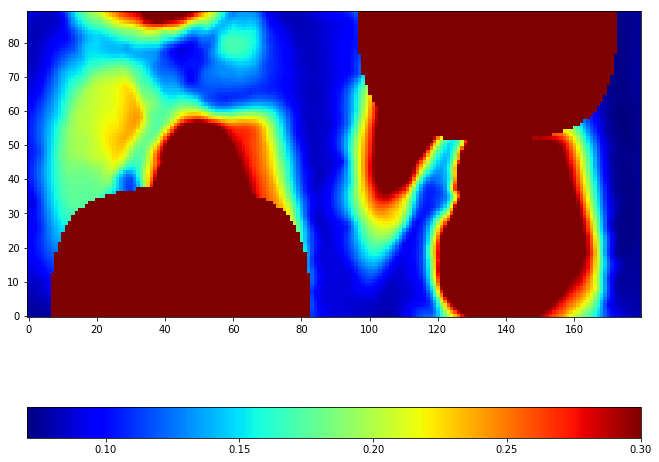

In [4]:
pl.FlooadPlot(pic=gt_map,flood_level=0.3)
plt.show()

### plot the minimum in each column of the `gt_map`

#### this is an idea to find connected parts that would form already an ideal path. In this notebook we focus on the cyan diamonds and we wish to find a minimal cost path connecting these two diamonds. For that one has to go around one organ at risk.

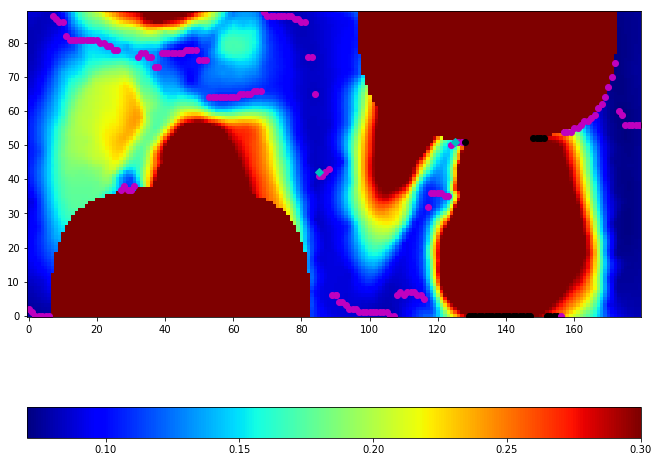

In [5]:
plt.figure(figsize=(11,11))

pl.FlooadPlot(pic=gt_map,flood_level=0.3)

for s in np.linspace(0,30,31) :
    pl.LinePlot(pic=gt_map,start=int(s))

plt.plot(125,51,'cD')
plt.plot(85,42,'cD')

plt.show()

#### The coordinates of the diamonds are given by and denoted as nest (start) and food (goal)

In [6]:
nest = (85,42)
food = (125,51)

In [7]:
def GetNeighbours (point) :
    """
    This function returns the points/pixels being the neighbours of the input point.
    In this set-up the neighbours can be either above, below or to the right of the 
    input point illustrated below:   
    
    n n
    i n
    n n
    
    i stands for input point and n denotes the neighbours.
    
    params:
        point      - is of type tuple. represents the coordinates (x,y) in pixel
                     units, i.e. in terms of the dimension of the color map
    returns :
        neighbours - is a list of tuples. Each list element is a tuple (x,y) of
                     points being the nrighbours of the input point
    """
    x = point[0]
    y = point[1]
    neighbours = [(x,y+1),(x+1,y+1),(x+1,y),(x+1,y-1),(x,y-1)]

    forbidden = []
    for n in neighbours :
        if (n[0]<0 or n[0]>179 or n[1]<0 or n[1]>89) :
            forbidden.append(n)
    
    for f in forbidden :
        neighbours.remove(f)
    
    return neighbours
    
    

In [8]:
class Ant :
    
    
    def __init__(self,birth_coordinates) :
        self.location = birth_coordinates
        self.track = [birth_coordinates]
        self.cost = 0.
        self.critical_steps = 0
        
    def AddMove (self,nextpoint) :
        self.location = nextpoint
        self.track.append(nextpoint)
    
    def AddCost (self,value) :
        self.cost += value
        

In [9]:
import random

In [10]:
def GetNextState (state_transition_probas,neigbours) :
    
    #perform random shuffeling of the 2 lists:
    #package = list(zip(state_transition_probas,neigbours))
    #random.shuffle(package)
    #probas, n = zip(*package)
    
    probas = state_transition_probas
    n = neigbours
    
    #print probas
    #print n
    
    random_uniform = np.random.rand()
    #print random_uniform
    summing = 0
    for i, p in enumerate(probas) :
        summing += p
        #print summing
        #print summing>=p
        if summing >= random_uniform :
            next_state = n[i]
            return next_state

In [11]:
class AntDecisionTable :#(location,destination,pheromone,distance,alpha=1.,beta=5.) :
    
    def __init__(self,pheromone,distance,alpha=1.,beta=5.,rho=0.) :

        self.eta_ij = distance #[destination[::-1]]
        self.tau_ij = pheromone
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
    
    def a_ij (self, location, destination) :
        loc = location
        dest = destination
        numerator = (self.tau_ij[loc,dest]*(1.-self.rho))**self.alpha * self.eta_ij[loc,dest]**self.beta
        
        denominator = 0.
        for n in GetNeighbours(point=loc) :
            denominator += (self.tau_ij[loc,n]*(1.-self.rho))**self.alpha * self.eta_ij[loc,n]**self.beta
        
        a_ij = numerator / denominator
        return a_ij
    
    def p_ij (self, location, destination) :
        loc = location
        dest = destination
        numerator = self.a_ij(location=loc,destination=dest)
        denominator = 0
        
        for n in GetNeighbours(point=loc) :
            denominator += self.a_ij(location=loc,destination=n)
        
        p_ij = numerator / denominator
        return p_ij
    
    def UpdatePheromone(self,colony,rho=0.5) :
        cost_in_generation = []
        no_of_ants = 1.*len(colony)
        for ant in colony :
            if ant.critical_steps < 10 :
                #cost_value = 1. / ant.cost
                track_length = len(ant.track)*1.
                #cost_value = track_length * cost_value

                """
                print 'ant no. ', i
                print 'cost per pixel step', ant.cost / track_length
                print 'antcost', ant.cost
                print 'resulting update',  1. / (ant.cost / track_length )
                """

                #cost_value = 1. / (ant.cost / track_length ) 
                cost_value = 1. / (ant.cost / track_length ) 
                #print cost_value

                for i,t in enumerate(ant.track[:-1]) :
                    pheromone_value = self.tau_ij[t,ant.track[i+1]]

                    #if pheromone_value < 20. :
                    if (pheromone_value < 3. and pheromone_value > 0.5 ) :
                        self.tau_ij[t,ant.track[i+1]] = pheromone_value + cost_value / (1.-rho) #* (1.-rho) / no_of_ants 
                    #print pheromone_value
                #print '------'
                cost_in_generation.append(ant.cost)


            for key in self.tau_ij:    
                self.tau_ij[key] *=  (1.-rho)
                #print self.tau_ij[key]
            """
            for x in xrange(180) :
                for y in xrange(90) :
                    for n in GetNeighbours((x,y)) :
                        self.tau_ij[(x,y),n] = self.tau_ij[(x,y),n] * (1.-rho) 
            """
            #self.tau_ij = self.tau_ij * (1.-rho) 
            #self.DeamonFeromone(ant=colony[np.argmin(cost_in_generation)],rho=rho)

    def DeamonFeromone (self,ant,rho,boost_factor=5.) :
        track_length = len(ant.track)*1.
        track_cost_perpixel = ant.cost / track_length / boost_factor
        
        cost_value = 1. / track_cost_perpixel
        
        for i,t in enumerate(ant.track[:-1]) :
            self.tau_ij[t,ant.track[i+1]] = self.tau_ij[t,ant.track[i+1]] * (1.-rho) + cost_value

        
        #return cost

In [21]:
pheromone_0 = {}
set_pheromone_const =  3.

dist_cost = {}

for x in xrange(180) :
    for y in xrange(90) :
        for n in ANT.GetNeighbours((x,y)) :
            pheromone_0[(x,y),n] = set_pheromone_const
            dist_cost[(x,y),n] = 1. / gt_map[n[::-1]]

In [22]:
reload(ANT)
reload(GRID)

<module 'ant_grid' from 'ant_grid.pyc'>

In [51]:
DecTable = GRID.AntDecisionTable(pheromone=pheromone_0, distance=dist_cost,alpha=1.,beta=1.)

reduced goal 0.299
no_of_critical_ants 0
0
minimal track 14
cost 15.0629756
cost per unit length 0.158557637895
amount of critical steps 0


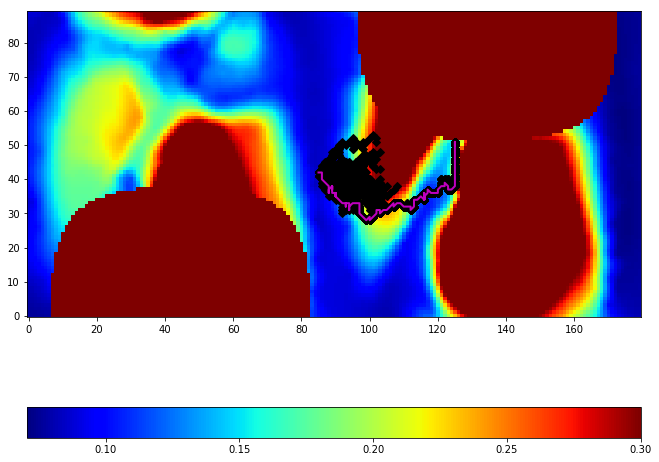

reduced goal 0.298
no_of_critical_ants 10
reduced goal 0.297
no_of_critical_ants 13
reduced goal 0.296
no_of_critical_ants 14
reduced goal 0.295
no_of_critical_ants 10
reduced goal 0.294
no_of_critical_ants 15
5
minimal track 6
cost 13.9203231
cost per unit length 0.158185489773
amount of critical steps 0


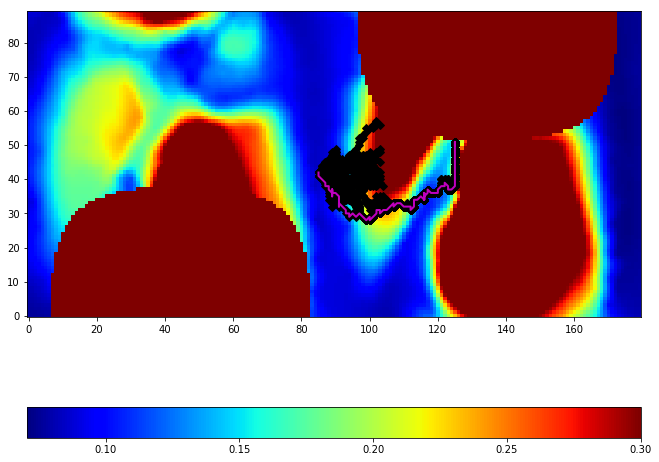

reduced goal 0.293
no_of_critical_ants 15
reduced goal 0.292
no_of_critical_ants 13
reduced goal 0.291
no_of_critical_ants 16
reduced goal 0.29
no_of_critical_ants 11
reduced goal 0.289
no_of_critical_ants 12
10
minimal track 15
cost 14.4175763
cost per unit length 0.158434904396
amount of critical steps 0


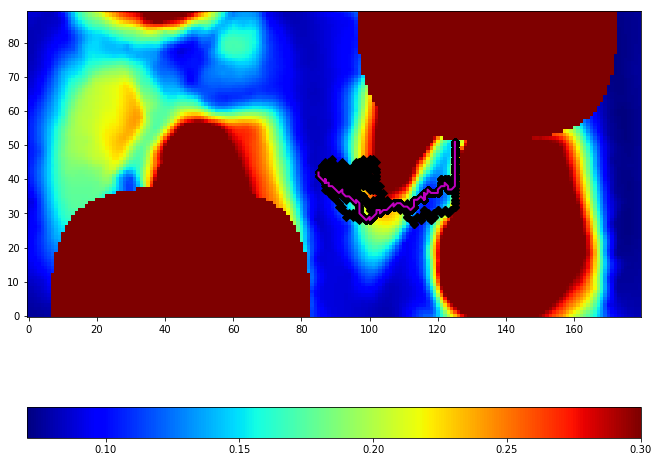

reduced goal 0.288
no_of_critical_ants 13
reduced goal 0.287
no_of_critical_ants 15
reduced goal 0.286
no_of_critical_ants 16
reduced goal 0.285
no_of_critical_ants 15
reduced goal 0.284
no_of_critical_ants 14
15
minimal track 26
cost 14.5677436
cost per unit length 0.156642404301
amount of critical steps 0


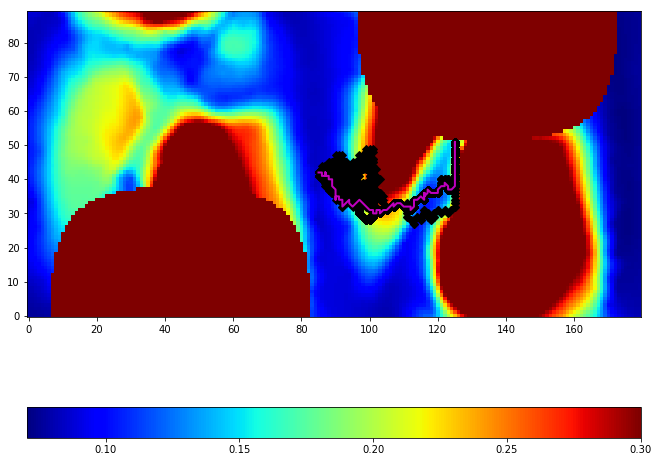

reduced goal 0.283
no_of_critical_ants 13
reduced goal 0.282
no_of_critical_ants 13
reduced goal 0.281
no_of_critical_ants 12
reduced goal 0.28
no_of_critical_ants 11
reduced goal 0.279
no_of_critical_ants 15
20
minimal track 12
cost 13.3230651
cost per unit length 0.160518856627
amount of critical steps 0


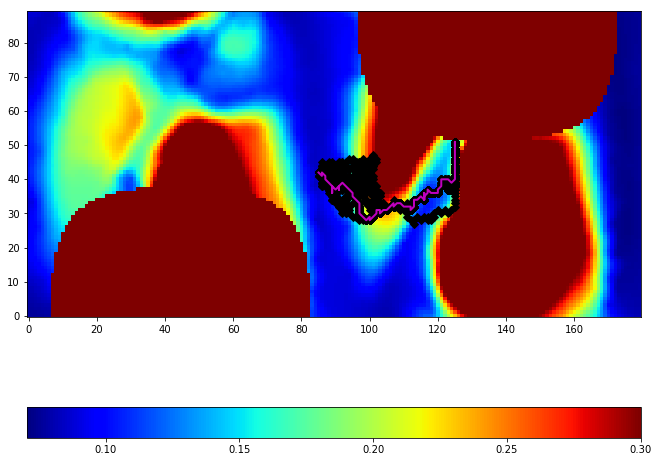

reduced goal 0.278
no_of_critical_ants 12
reduced goal 0.277
no_of_critical_ants 19
reduced goal 0.276
no_of_critical_ants 16
reduced goal 0.275
no_of_critical_ants 14
reduced goal 0.274
no_of_critical_ants 9
25
minimal track 26
cost 14.0938824
cost per unit length 0.160157754545
amount of critical steps 0


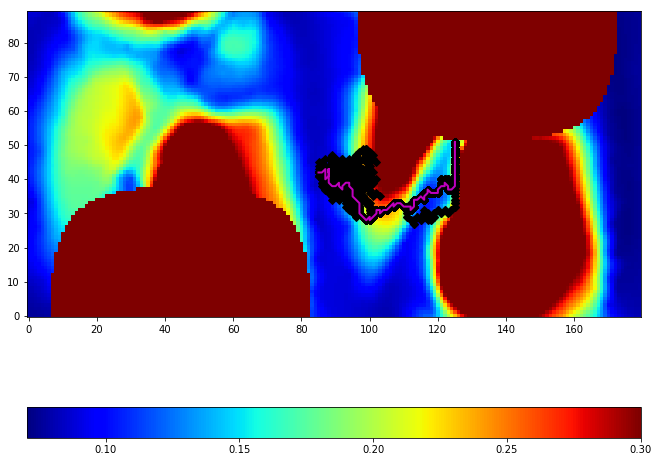

reduced goal 0.273
no_of_critical_ants 12
reduced goal 0.272
no_of_critical_ants 18
reduced goal 0.271
no_of_critical_ants 14
reduced goal 0.27
no_of_critical_ants 15
reduced goal 0.269
no_of_critical_ants 18
30
minimal track 29
cost 13.7420369
cost per unit length 0.157954447126
amount of critical steps 0


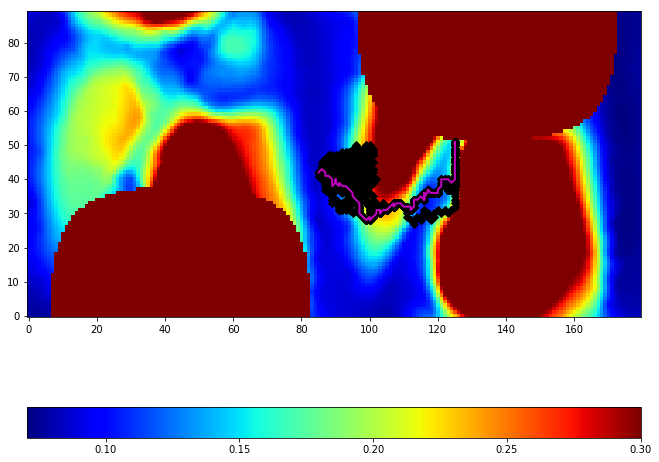

reduced goal 0.268
no_of_critical_ants 18
reduced goal 0.267
no_of_critical_ants 11
reduced goal 0.266
no_of_critical_ants 20
reduced goal 0.265
no_of_critical_ants 17
reduced goal 0.264
no_of_critical_ants 12
35
minimal track 3
cost 13.6911492
cost per unit length 0.159199409302
amount of critical steps 0


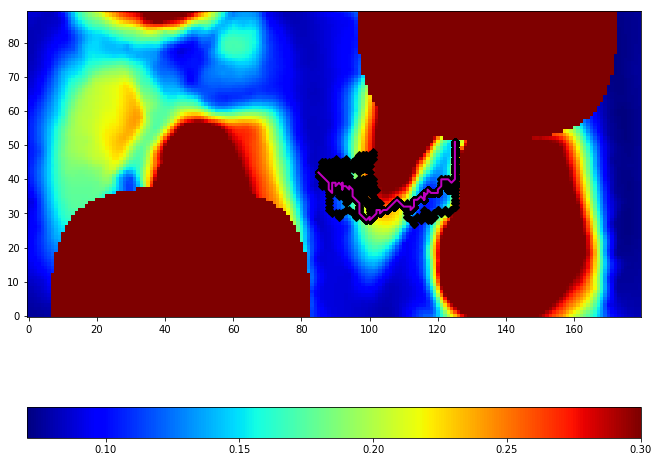

reduced goal 0.263
no_of_critical_ants 15
reduced goal 0.262
no_of_critical_ants 14
reduced goal 0.261
no_of_critical_ants 12
reduced goal 0.26
no_of_critical_ants 16
reduced goal 0.259
no_of_critical_ants 17
40
minimal track 1
cost 13.0584422
cost per unit length 0.1632305275
amount of critical steps 0


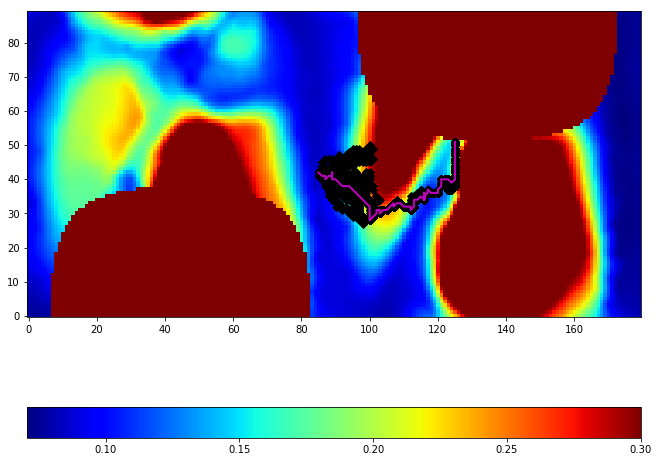

reduced goal 0.258
no_of_critical_ants 12
reduced goal 0.257
no_of_critical_ants 15
reduced goal 0.256
no_of_critical_ants 14
reduced goal 0.255
no_of_critical_ants 17
reduced goal 0.254
no_of_critical_ants 19
45
minimal track 14
cost 12.4964437
cost per unit length 0.160210816667
amount of critical steps 1


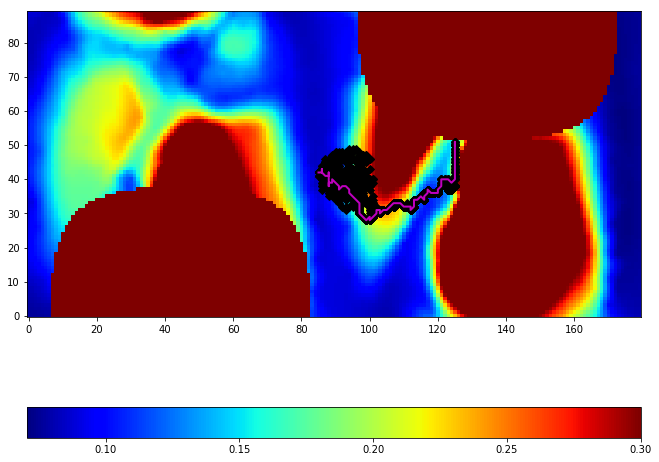

reduced goal 0.253
no_of_critical_ants 25
reduced goal 0.252
no_of_critical_ants 28
reduced goal 0.251
no_of_critical_ants 26
reduced goal 0.25
no_of_critical_ants 24
reduced goal 0.251
no_of_critical_ants 30
50
minimal track 25
cost 15.4926633
cost per unit length 0.150414206796
amount of critical steps 1


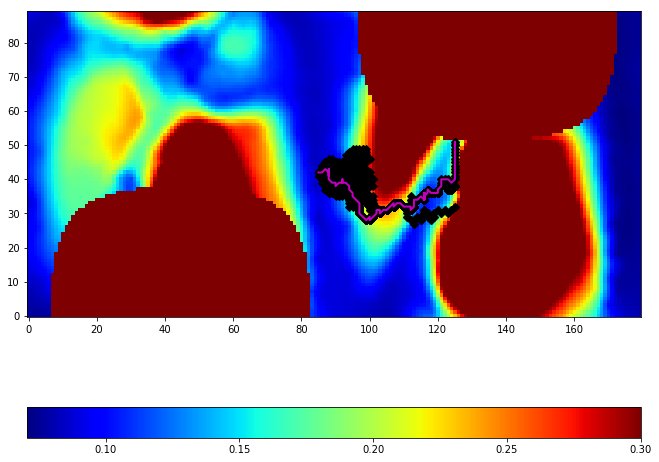

reduced goal 0.25
no_of_critical_ants 28
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 27
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 28
55
minimal track 0
cost 3.5415575
cost per unit length 0.1416623
amount of critical steps 2


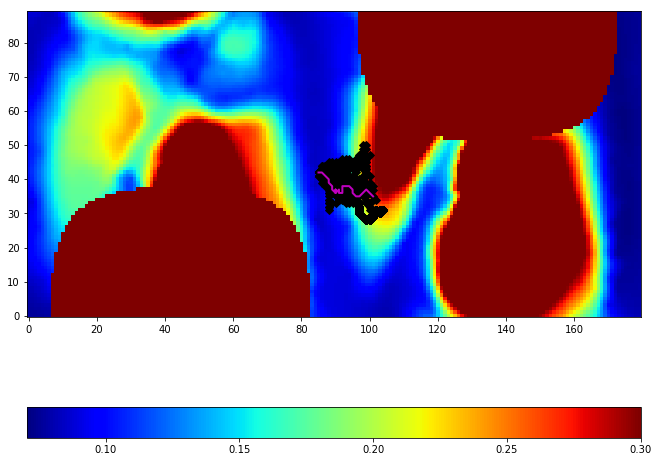

reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 28
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 25
reduced goal 0.251
no_of_critical_ants 30
60
minimal track 18
cost 12.7334167
cost per unit length 0.165369048052
amount of critical steps 1


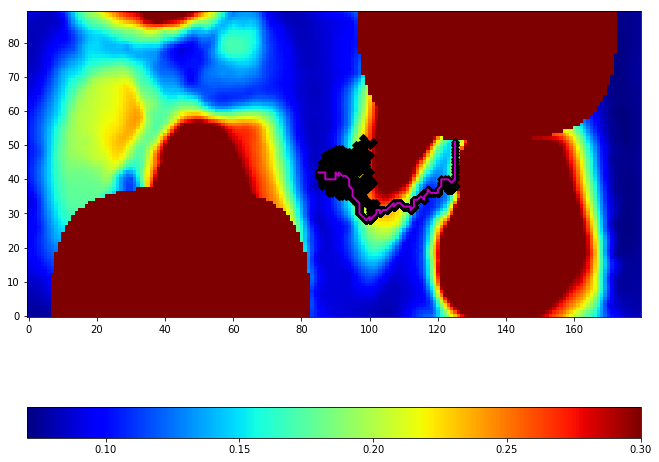

reduced goal 0.25
no_of_critical_ants 29
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 24
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 27
65
minimal track 0
cost 3.5456395
cost per unit length 0.15415823913
amount of critical steps 2


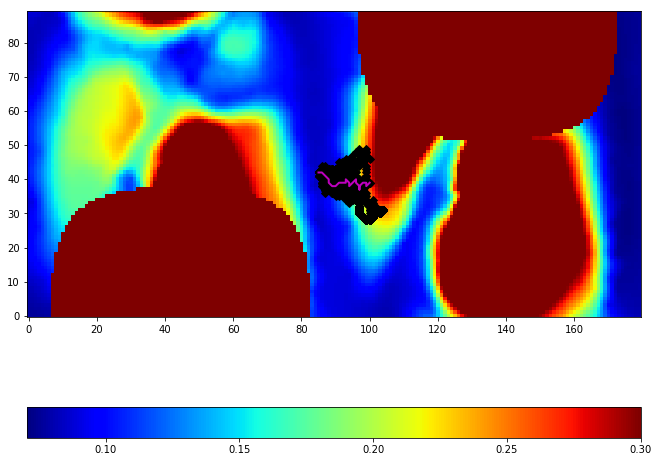

reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 27
reduced goal 0.251
no_of_critical_ants 30
reduced goal 0.25
no_of_critical_ants 24
reduced goal 0.251
no_of_critical_ants 30
70
minimal track 19
cost 13.5867978
cost per unit length 0.15798602093
amount of critical steps 1


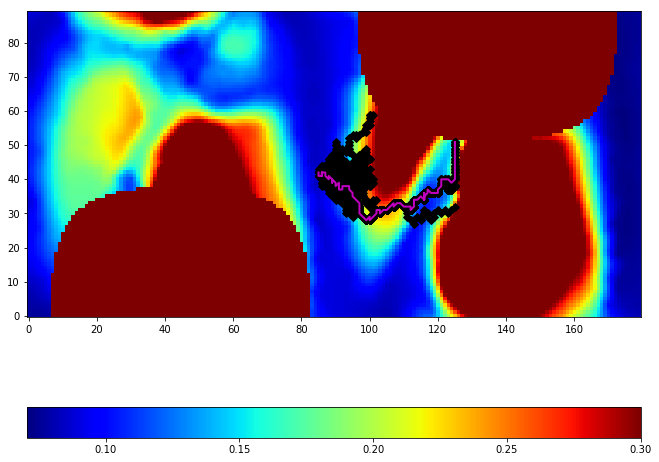

total time:  135.006095171


In [52]:
go = time.time()
no_of_critical_ants = 0
cost_goal_generation = 0.3
for generation in xrange(71) :
    
    if no_of_critical_ants < 30 :
        cost_goal_generation -= 0.001 
    else : cost_goal_generation += 0.001
        
    print 'reduced goal', cost_goal_generation
    print 'no_of_critical_ants', no_of_critical_ants
    
    ant_colony = []
    no_of_critical_ants = 0
        
    for m in xrange(30) :
        ant = ANT.Ant(birth_coordinates=nest)
        ant_colony.append(ant) 
            
        while (ant.location != food) :

            loc = ant.location
            state_transition_probas = []
            
            neigbours = ANT.GetNeighbours(point=loc)
            
            
            for n in neigbours :
                state_transition_probas.append(DecTable.p_ij(location=loc,destination=n))

            next_state = GRID.GetNextState(state_transition_probas=state_transition_probas,neigbours=neigbours)
            ant.AddMove(nextpoint=next_state)
            
            colormap_value = 1./ DecTable.eta_ij[loc,next_state]
            ant.AddCost(value=colormap_value)
            
            #print colormap_value
            if colormap_value >= cost_goal_generation :
                ant.critical_steps += 1
            
            if ant.critical_steps > 1 :
                #print 'dead'
                no_of_critical_ants += 1
                break
                
            
            
            # if level reached of the food one, go up or down
            if (ant.location[0] == food[0]) :
                
                while loc[1] != food[1] :
                    loc = ant.location

                    #walk up
                    if loc[1] < food[1] :
                        next_state = (loc[0],loc[1]+1)
                    else :
                        next_state = (loc[0],loc[1]-1)
                        
                    ant.AddMove(nextpoint=next_state)
                    #print 1./DecTable.eta_ij[loc,next_state]
                    ant.AddCost(value=1./DecTable.eta_ij[loc,next_state])
                break

                
            
    DecTable.UpdatePheromone(colony=ant_colony)
    
    """
    for n in ANT.GetNeighbours((108,45)) :
        print n
        print DecTable.p_ij(location=(108,45), destination=n)
    """
    if generation%5 == 0 :
        print generation
        
        plt.figure(figsize=(11,11))
        pl.FlooadPlot(pic=gt_map,flood_level=0.3)

        cost_in_generation = []
        for a in ant_colony :
            track_length = 1.*len(a.track)
            pl.PlotTrack(track=a.track)
            #plt.pause(0.05)
            if a.critical_steps < 2 :
                #print 'hi'
                cost_in_generation.append(a.cost / track_length)
            else :   
                cost_in_generation.append(1.)
            #print TrackCost(ant=a,cost_map=astar_landscape)
        print 'minimal track', np.argmin(cost_in_generation)
        print 'cost', ant_colony[np.argmin(cost_in_generation)].cost
        print 'cost per unit length', ant_colony[np.argmin(cost_in_generation)].cost / len(ant_colony[np.argmin(cost_in_generation)].track)
        print 'amount of critical steps', ant_colony[np.argmin(cost_in_generation)].critical_steps
        
        
        pl.HighlightTrack(ant_colony[np.argmin(cost_in_generation)].track)
        plt.show()
        
stop = time.time()

print 'total time: ', stop-go

In [16]:
p =

SyntaxError: invalid syntax (<ipython-input-16-3ca8a2dbc448>, line 1)

In [ ]:
p = (99,45)

for n in ANT.GetNeighbours(point=p) :
    print n
    print DecTable.p_ij(location=p,destination=n)

In [ ]:
print cost_in_generation
for ant in ant_colony :
    print ant.critical_steps

In [ ]:
DecTable.eta_ij

In [ ]:
DecTable.tau_ij

In [ ]:
print 10**0.3
print 10**0.1


print np.log(1.+0.1)
print np.log(1.+0.3)
print np.log(1.+3)


In [ ]:
for y in xrange(89) :
    print DecTable.eta_ij[(98,y),(99,y+1)]

In [ ]:
ant = ant_colony[-1]
print ant.track
print len(ant.track)


In [ ]:
"""plt.figure(figsize=(11,11))

for a in ant_colony :
    pl.PlotTrack(track=a.track)
        
pl.FlooadPlot(pic=astar_landscape,flood_level=0.3)
plt.show()"""

In [ ]:
#DecTable.tau_ij
print 'start', start

loc = start
#loc = (100,42)

for n in GetNeighbours(point=loc) :
    
    print 'proba going to neighbour', n
    print DecTable.p_ij(location=loc,destination=n)

In [ ]:
print nest
print food

In [ ]:
t_manual = [(85,42),(85,41),(85,40),(85,39),(85,38),(85,37),(85,36),(85,35),(85,34),(85,33),(85,32),
            (86,31),(86,30),(86,29),(86,29),(86,28),(86,27),(86,26),(87,25),(87,24),(87,23),(87,22),
            (87,21),(87,21),(87,20),(88,19),(89,19),(90,19),(90,18),(90,17),(90,16),(90,15),(90,14),
            (90,13),(90,12),(90,11),(90,10),(90,9),(90,8),(90,7),(90,6),(90,5),(90,4),(90,3),(91,3),
            (92,3),(93,3),(94,3),(95,3),(96,3),(97,3),(98,3),(99,3),(100,3),(101,3),(102,3),
            (103,3),
            (104,3),
            (105,3),
            (106,3),
            (107,3),
            (108,3),
            (109,3),(110,3),
            (111,3),
            (111,4),
            (111,5),
            (111,6),
            (111,7),
            (111,8),
            (111,9),
            (111,10),
            (111,11),
            (111,12),
            (111,13),
            (111,14),
            (111,15),
            (111,16),
            (111,17),
            (111,18),
            (111,19),
            (111,20),
            (112,21),
            (112,22),
            (112,23),
            (113,24),
            (114,25),
            (114,26),
            (115,27),
            (115,28),
            (115,29),
            (115,30),
            (115,31),
            (115,32),
            (116,33),
            (117,34),
            (117,35),
            (118,36),
            (118,37),
            (118,38),
            (119,39),
            (120,40),            
            (120,41),            
            (121,42),            
            (121,43),            
            (121,44),            
            (122,45),            
            (123,46),            
            (124,47),            
            (124,48),            
            (124,49),            
            (125,50),            
            (125,51),            
            
           ]

In [ ]:
plt.figure(figsize=(11,11))
print 'cost of manual path',np.sum([astar_landscape[q[::-1]] for q in t_manual])
print 'cost per pixel of manual path',np.sum([astar_landscape[q[::-1]] for q in t_manual] ) / len(t_manual)*1.
pl.HighlightTrack(t_manual)
pl.FlooadPlot(pic=astar_landscape,flood_level=0.3)
plt.show()

In [ ]:
ant = ant_colony[-1]

In [ ]:
print ant.track
print ant.cost

In [ ]:
print astar_landscape[(85,42)[::-1]]
print np.sum([astar_landscape[q[::-1]] for q in ant.track])

In [ ]:
print 9.5749419 +0.0838915

In [ ]:
plt.figure(figsize=(11,11))
pl.PlotTrack(track=path)
pl.FlooadPlot(pic=astar_landscape,flood_level=0.3)
plt.show()

In [ ]:
#print state_transition_probas
#print neigbours

In [ ]:
#print ant.track

In [ ]:
"""def TrackCost (ant, cost_map) :
    cost = 0
    for point in ant.track :
        cost += cost_map[point[::-1]]
    return cost"""

In [ ]:
"""reload(pl)
plt.figure(figsize=(11,11))
for a in ant_colony :
    pl.PlotTrack(track=a.track)
    print TrackCost(ant=a,cost_map=astar_landscape)
pl.FlooadPlot(pic=astar_landscape,flood_level=0.3)
plt.show()
"""